In [1]:
import matplotlib.pyplot as plt
from wavebench.plot_utils import remove_frame

In [2]:
import ml_collections
import numpy as np
import cv2
from wavebench.utils import seed_everything
from wavebench import wavebench_dataset_path
import os

medium_collection = {}

for medium in ['gaussian_random_field', 'gaussian_lens']:
  config = ml_collections
  config.medium_type = medium #'gaussian_random_field'


  config.domain_sidelen = 128
  config.domain_dx = 8
  # the above seetings give a domain of 1024 km x 1024 km

  config.medium_source_loc = (50, 55)
  config.medium_density = 2650
  config.pml_size = 2

  #  define properties of the propagation medium
  min_wavespeed = 1400
  max_wavespeed = 4000

  if config.medium_type == 'gaussian_lens':
    point_mass_strength = -31000
    z = np.ones((config.domain_sidelen,config.domain_sidelen))
    z[config.medium_source_loc] = point_mass_strength
    medium_sound_speed = cv2.GaussianBlur(
        z,
        ksize=(0, 0),
        sigmaX=50,
        borderType=cv2.BORDER_REPLICATE)
  elif config.medium_type == 'gaussian_random_field':
    medium_sound_speed = np.fromfile(
      os.path.join(
        wavebench_dataset_path, "time_varying/wavespeed/cp_128x128_00001.H@"),
      dtype=np.float32).reshape(128, 128)

    if config.domain_sidelen != 128:
      medium_sound_speed = interpolate(
          medium_sound_speed,
          size=[config.domain_sidelen, config.domain_sidelen],
          mode='bicubic')
  else:
    raise NotImplementedError

  medium_sound_speed -= medium_sound_speed.min()
  medium_sound_speed /= medium_sound_speed.max()

  config.medium_sound_speed = medium_sound_speed*(
  max_wavespeed - min_wavespeed) + min_wavespeed

  medium_collection[medium] = config.medium_sound_speed


## Reverse Time Continuation (RTC) dataset

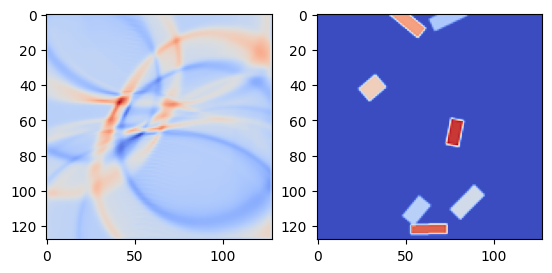

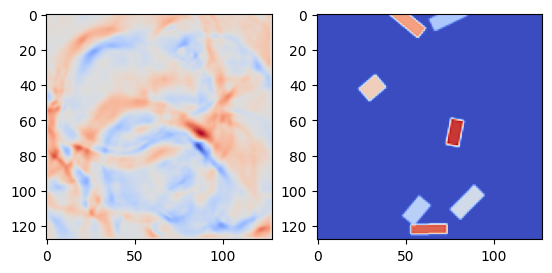

In [3]:
from wavebench.dataloaders.rtc_loader import get_dataloaders_rtc_thick_lines

rtc_loaders = {}

for medium_type in ['gaussian_lens', 'gaussian_random_field']:
  loaders = get_dataloaders_rtc_thick_lines(
    medium_type=medium_type,
    # sidelen=512,
  )

  idx = 1
  a, b = loaders['train'].dataset.__getitem__(idx)

  fig, axes = plt.subplots(1, 2)

  axes[0].imshow(a.squeeze().numpy(), cmap='coolwarm')
  axes[1].imshow(b.squeeze().numpy(), cmap='coolwarm')
  rtc_loaders[medium_type] = loaders

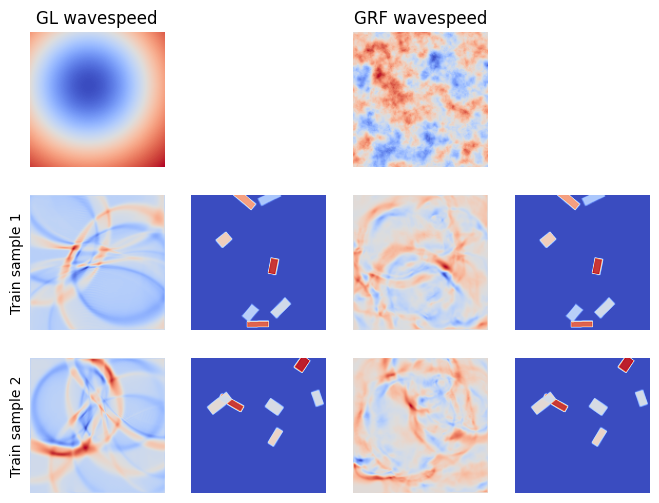

In [4]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 6))

gs = GridSpec(3, 4, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax11.imshow(
  medium_collection['gaussian_lens'],
  'coolwarm')
ax11.set_title("GL wavespeed")

ax12 = fig.add_subplot(gs[0, 2])
ax12.imshow(
  medium_collection['gaussian_random_field'],
  'coolwarm')
ax12.set_title("GRF wavespeed")

# rtc, gaussian_lens
a, b = rtc_loaders['gaussian_lens']['train'].dataset.__getitem__(1)

ax21 = fig.add_subplot(gs[1, 0])
ax21.imshow(
  a.squeeze().numpy(),
  'coolwarm')
ax21.set_ylabel("Train sample 1")

ax22 = fig.add_subplot(gs[1, 1])
ax22.imshow(
  b.squeeze().numpy(),
  'coolwarm')

# rtc, gaussian_random_field
a, b = rtc_loaders['gaussian_random_field']['train'].dataset.__getitem__(1)

ax23 = fig.add_subplot(gs[1, 2])
ax23.imshow(
  a.squeeze().numpy(),
  'coolwarm')

ax24 = fig.add_subplot(gs[1, 3])
ax24.imshow(
  b.squeeze().numpy(),
  'coolwarm')


# rtc, gaussian_lens
a, b = rtc_loaders['gaussian_lens']['train'].dataset.__getitem__(2)

ax31 = fig.add_subplot(gs[2, 0])
ax31.imshow(
  a.squeeze().numpy(),
  'coolwarm')
ax31.set_ylabel("Train sample 2")

ax32 = fig.add_subplot(gs[2, 1])
ax32.imshow(
  b.squeeze().numpy(),
  'coolwarm')

# rtc, gaussian_random_field
a, b = rtc_loaders['gaussian_random_field']['train'].dataset.__getitem__(2)

ax33 = fig.add_subplot(gs[2, 2])
ax33.imshow(
  a.squeeze().numpy(),
  'coolwarm')

ax34 = fig.add_subplot(gs[2, 3])
ax34.imshow(
  b.squeeze().numpy(),
  'coolwarm')

[remove_frame(ax) for ax in [ax11, ax12, ax21, ax22, ax23, ax24, ax31, ax32, ax33, ax34]]
plt.savefig("rtc_demo.pdf", format="pdf", bbox_inches="tight")

## Inverse Source (IS) dataset

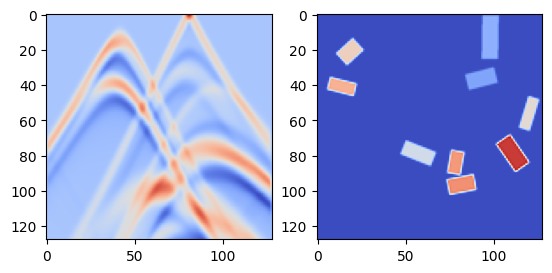

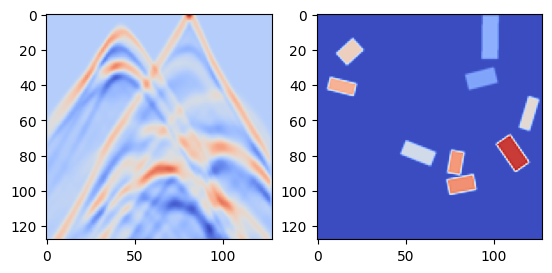

In [5]:
from wavebench.dataloaders.is_loader import get_dataloaders_is_thick_lines
import matplotlib.pyplot as plt


is_loaders = {}


for medium_type in ['gaussian_lens', 'gaussian_random_field']:
  loaders = get_dataloaders_is_thick_lines(
    medium_type=medium_type,
  )

  idx = 4
  a, b = loaders['train'].dataset.__getitem__(idx)


  fig, axes = plt.subplots(1, 2)

  axes[0].imshow(a.squeeze().numpy(), cmap='coolwarm')
  axes[1].imshow(b.squeeze().numpy(), cmap='coolwarm')

  is_loaders[medium_type] = loaders


In [6]:
loaders['train'].dataset.dataset.measurements.abs().max()

tensor(0.9914)

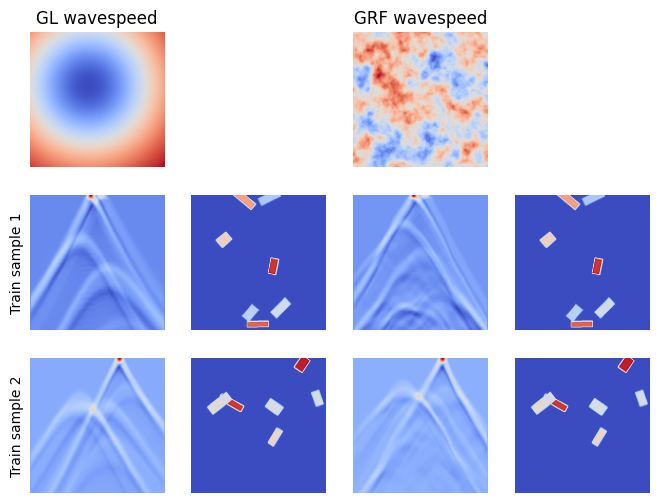

In [7]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 6))

gs = GridSpec(3, 4, figure=fig)
ax11 = fig.add_subplot(gs[0, 0])
ax11.imshow(
  medium_collection['gaussian_lens'],
  'coolwarm')
ax11.set_title("GL wavespeed")

ax12 = fig.add_subplot(gs[0, 2])
ax12.imshow(
  medium_collection['gaussian_random_field'],
  'coolwarm')
ax12.set_title("GRF wavespeed")

# is, gaussian_lens
a, b = is_loaders['gaussian_lens']['train'].dataset.__getitem__(1)

ax21 = fig.add_subplot(gs[1, 0])
ax21.imshow(
  a.squeeze().numpy(),
  'coolwarm')
ax21.set_ylabel("Train sample 1")

ax22 = fig.add_subplot(gs[1, 1])
ax22.imshow(
  b.squeeze().numpy(),
  'coolwarm')

# rtc, gaussian_random_field
a, b = is_loaders['gaussian_random_field']['train'].dataset.__getitem__(1)

ax23 = fig.add_subplot(gs[1, 2])
ax23.imshow(
  a.squeeze().numpy(),
  'coolwarm')


ax24 = fig.add_subplot(gs[1, 3])
ax24.imshow(
  b.squeeze().numpy(),
  'coolwarm')

# rtc, gaussian_lens
a, b = is_loaders['gaussian_lens']['train'].dataset.__getitem__(2)

ax31 = fig.add_subplot(gs[2, 0])
ax31.imshow(
  a.squeeze().numpy(),
  'coolwarm')
ax31.set_ylabel("Train sample 2")

ax32 = fig.add_subplot(gs[2, 1])
ax32.imshow(
  b.squeeze().numpy(),
  'coolwarm')

# rtc, gaussian_random_field
a, b = is_loaders['gaussian_random_field']['train'].dataset.__getitem__(2)

ax33 = fig.add_subplot(gs[2, 2])
ax33.imshow(
  a.squeeze().numpy(),
  'coolwarm')

ax34 = fig.add_subplot(gs[2, 3])
ax34.imshow(
  b.squeeze().numpy(),
  'coolwarm')

[remove_frame(ax) for ax in [ax11, ax12, ax21, ax22, ax23, ax24, ax31, ax32, ax33, ax34]]

plt.savefig("is_demo.pdf", format="pdf", bbox_inches="tight")